<font color='blue'> **Zahasky_04_05** </font> 

In [1]:
import sys; import flopy; import os; import time; import numpy as np  ; import matplotlib.pyplot as plt ; from pathlib import Path; import pandas as pd; import string ; 
from scipy.special import erfc as erfc   ; from scipy.special import erf as erf ; EXF = 'E:\\15_REPOS\\00_BETAMI\\bin\\MF2005.exe'    ; EXT = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64.exe'
import flopy.utils.binaryfile as bf      ; _R=Path("_R"); _R.mkdir(exist_ok=True); TA=Path("_R/_04_05"); TA.mkdir(exist_ok=True)      ; TB=Path(TA/"TB"); TB.mkdir(exist_ok=True)

SEC='S';CM='CM'  ;nrow=1;ncol=21;delc=4.4;delr = 0.5  ;Lx=(ncol-1)*delr                 ;nlay=1 ;delv=4.4   ; laytyp=0;hk=1       ; DISP=0.3 ; VV = 0.014            ; perlen_MF=[30*60]    
NPRS = 100       ; TIMPRS = np.linspace(0, np.sum(perlen_MF), NPRS, endpoint=False)                         ; RO=0.3 ;q=VV*RO     ; NN = str(round(Lx/(q/RO)/60))    # ** VV Key ** qx
print("Based on discharge and model length the approximate ~ WINakthrough time = " + NN + "min", 'of 30"')                        ; itype = -1 ; c0 = 1      ;spd_MT={0:[0,0,0,c0,itype]}

icbund = np.ones  ((nlay, nrow, ncol), dtype=int)     ; IB = np.ones  ((nlay, nrow, ncol), dtype=int)      ; IB[0, 0, 0] = -1      ; IB[0, 0,-1] = -1  
SCC  = np.zeros ((nlay, nrow, ncol), dtype=float)     ; IC = np.zeros ((nlay, nrow, ncol), dtype=float)   ; H1 = q * Lx / hk      ; IC  [0, 0, 0] = H1   #itmuni=1;lenuni=3  # MF|MT

Based on discharge and model length the approximate ~ WINakthrough time = 12min of 30"


In [2]:
MF  = flopy.modflow.Modflow (modelname='MF', model_ws=TA, exe_name=EXF)
dis = flopy.modflow.ModflowDis (MF, nlay=nlay, nrow=nrow, ncol=ncol, nper=len(perlen_MF),delr=delr, delc=delc, top=0., botm=[0 - delv], perlen=perlen_MF)  # itmuni=itmuni, lenuni=lenuni
bas = flopy.modflow.ModflowBas (MF, ibound=IB, strt=IC)     ; lpf = flopy.modflow.ModflowLpf (MF, hk=hk, laytyp = laytyp)
pcg = flopy.modflow.ModflowPcg (MF)                         ; lMT = flopy.modflow.ModflowLmt (MF)              ; oc = flopy.modflow.ModflowOc(MF)
MF.write_input() ; MF.run_model(silent = True)              ; #chd = flopy.modflow.ModflowChd (MF, stress_period_data=chdspd)


MT  = flopy.mt3d.Mt3dms   (modelname='MT', model_ws=TA, exe_name=EXT, modflowmodel=MF)  ; 
btn = flopy.mt3d.Mt3dBtn (MT, icbund=icbund, prsity=RO, sconc=SCC, tunit=SEC, lunit=CM, nprs=NPRS, timprs=TIMPRS)          
MIX = -1     ; adv = flopy.mt3d.Mt3dAdv (MT, mixelm=MIX, percel=0.5)    ; dsp = flopy.mt3d.Mt3dDsp (MT, al=DISP)                         
ssm = flopy.mt3d.Mt3dSsm (MT, stress_period_data = spd_MT )             ; gcg = flopy.mt3d.Mt3dGcg (MT, cclose=1e-6)                    ; MT.write_input() ; MT.run_model(silent=True) 

(False, [])

<font color='orange'> **RES ____________________________________________________________________________________________________________** </font> 

In [3]:
ucnobj  = flopy.utils.UcnFile(os.path.join(TA, 'MT3D001.UCN'))  ; CC  = ucnobj.get_alldata()  ; times = np.array(ucnobj.get_times())             #; print("T=",times.shape)
hdobj   = flopy.utils.HeadFile(os.path.join(TA, 'MF'+'.hds'))   ; HH = hdobj.get_data()                                  #  ; print("C=", CC.shape)  # print("H=",HH.shape)  
hk_array = MF.lpf.hk.array                                      ; y, x, z = MF.dis.get_node_coordinates()   ; pd.DataFrame(x).to_csv(TB/'04d_Grid_X.csv')     
CONC  = CC.reshape (CC.shape [0], -1)  ; aa = pd.DataFrame(CONC)  ; aa.to_csv(TB/'04c_C.csv')   # ; print("C2=",aa.shape) ; SHPH
#SHPH = HH.reshape (HH.shape[0], -1)   ; aa = pd.DataFrame(SHPH)  ; aa.to_csv(TB/'04b_H.csv')   ; pd.DataFrame(times).to_csv  (TB/'04a_T.csv')   ;  #; print("H2=",aa.shape) 

CC: (101, 1, 1, 21)
H max: 0.042


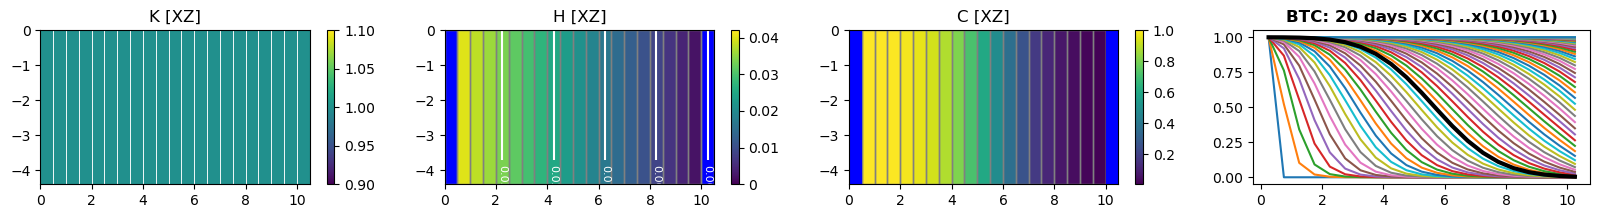

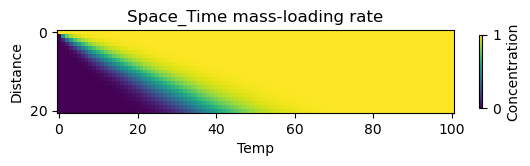

In [4]:
MG=MF.lpf.vka.array  ; WIN = 20  ; print('CC:',CC.shape)

fig = plt.figure(figsize=(20, 2))               ; VV1=np.min(HH[0]) ; VV2=np.max(HH[0])   ; LV  = np.arange(VV1, VV2, VV2/5) ; print('H max:',VV2)
ax=fig.add_subplot(141)       ; SX=flopy.plot.PlotCrossSection(model=MF, line={'Row': 0}) ; VK  = SX.plot_array(MG) ; SX.plot_grid(colors='white', lw=0.5) ; plt.colorbar(VK) ;plt.title("K [XZ]")
ax=fig.add_subplot(142)       ; SU=flopy.plot.PlotCrossSection(model=MF, line={'Row': 0}) ; UU  = SU.contour_array(HH, levels=LV, colors='w')       ; plt.clabel(UU,colors='w',fontsize=8)
HV=SU.plot_array(HH,head=HH)  ; fig.colorbar(HV, orientation='vertical', format='%0.3g')  ;       SU.plot_ibound(head=HH)                           ; SU.plot_grid() ; plt.title("H [XZ]")
ax=fig.add_subplot(143)       ; SX=flopy.plot.PlotCrossSection(model=MF, line={'Row': 0}) ; VK  = SX.plot_array(CONC[WIN]);SX.plot_grid();plt.colorbar(VK) ;plt.title("C [XZ]");SX.plot_ibound(head=HH)
ax=fig.add_subplot(144)       
for t in range(0, len(times)):      CON_A = CC[t, 0, 0, :]  ; plt.plot(x, CON_A)    
CON_A = CC[WIN, 0, 0, :]                                    ; plt.plot(x, CON_A,lw=3.0, color = 'black' )  ;plt.title('BTC: %1.0f days [XC] ..x(10)y(1)' %(WIN), fontweight='bold'); plt.show()
plt.imshow(CONC.T, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Concentration', shrink=0.2)  ; plt.title('Space_Time mass-loading rate') ; plt.xlabel('Temp') ; plt.ylabel('Distance') ; plt.show()

In [5]:
NSTP = [1]+[1]*2                    ; OC_S = {}                                                     #CBC = bf.CellBudgetFile(TA/'MF.cbc')
for kper in range(len(perlen_MF)):                 
    for kstp in range(NSTP[kper]):          OC_S[(kper, kstp)] = ['save head','save budget']        # CBC = bf.CellBudgetFile(TA/'MF.cbc')
OC_S                                # see __________________ oc = flopy.modflow.ModflowOc(MF,stress_period_data=OC_S,compact=True)

{(0, 0): ['save head', 'save budget']}